# 4-th order Runge-Kutta (RK4) integrator for Quantum Liouville's Dynamics 

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)

2. [Closed quantum system](#closed) 
    
3. [Open quantum system](#open)
    

### A. Learning objectives

- to integrate Quantum Liouville's equation (QLE) of motion using RK4 integrator
- to introduce the decoherence terms in the QLE

### B. Use cases

- [Integrating Quantum Liouville equation](#qcl-1) | [also here](#qcl-2)
- [Computing energy by the density matrix](#energy-1)


### C. Functions

- `liblibra::libintegrators`
  - [`RK4`](#RK4-1) | [also here](#RK4-2)
  

### D. Classes and class members

None    

## 1. General setups
<a name="setups"></a> [Back to TOC](#TOC)

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

## 2. Dynamics of a closed quantum system
<a name="closed"></a> [Back to TOC](#TOC)

The quantum Liouville's equation (QLE) is of the following form:

\\[ \frac{\partial \hat \rho}{\partial t} = \frac{1}{i \hbar} [ \hat H, \hat \rho ]  \\]   (1a)

The current implementation of the RK4 integrator in Libra solves the ODE of the general form:

\\[ \frac{dZ}{dt} = f(Z) \\]   (2)

where Z is a complex-valued n x m matrix of arbitrary dimensions.

The dynamics described by such an equation is non-dissipative and remains fully coherent.

In this problem we consider the dynamics in a simple 2-level system (and expect to get some Rabi oscillations)

So, the Hamiltonian will be taken as:

$$
    H = \begin{pmatrix}
    E_{0} & V \\
    V & E_{1} \\    
    \end{pmatrix}
$$

Here, $E_0$, $E_1$, and $V$ are all constants for simplicity

The function $f(Z)$ is simply given by the commutator of the operators, which is given via a multiplication of the matrices in different orders. 

As in the [classical mechanical example](../1_runge_kutta_4th_order/tutorial.ipynb), we need to define a function which would return the derivative function that appears on the RHS of the ODE. Unlike that example, we now treat Z variable and the corresponding derivative as the matrices. Moreover, the Z matrix is juzt taken as the density matrix, $\rho$

In [2]:
def derivatives(rho, params):
    """
    rho - density matrix
    H - Hamiltonian computed using the input parameters
    
    -i * [H, rho] = -i *( H * rho - rho * H)
    
    """
    
    nstates = rho.num_of_rows    
    Ham = params["Ham"]    # CMATRIX 
                
    der = CMATRIX(nstates, nstates)
    
    der = (Ham * rho - rho * Ham) * (-1.0j)
                    
    return der


Next, lets define the function to compute energies
<a name="energy-1">

In [3]:
def energies(rho, params):        
    return (rho * params["Ham"]).tr().real    

And a function to plot the energies vs time as well as the phase space portraits

In [4]:
def plot(T, Etot, pop00, pop11, coh_re, coh_im):
    
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,2,1)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')    
    plt.plot(T, Etot, label='Total energy', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Density matrix')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Matrix element')
    plt.plot(T, pop00, label='Population 0', linewidth=2, color = colors["11"])     
    plt.plot(T, pop11, label='Population 1', linewidth=2, color = colors["21"])     
    plt.plot(T, coh_re, label='Real (coherence)', linewidth=2, color = colors["31"])     
    plt.plot(T, coh_im, label='Imag (coherence)', linewidth=2, color = colors["32"])     
    plt.legend()
        
    plt.show()
    plt.close()

Finally, lets define the final, "main" function to do the integration.

Note how the function calls the **RK4** function defined in the *libintegrators* library of Libra
<a name="qcl-1"></a><a name="RK4-1"></a>

In [5]:
def run_simulations():
    
    # Initial conditions
    rho = CMATRIX(2, 2)
    rho.set(0,0, 1.0+0.0j);  rho.set(0,1, 0.0+0.0j);
    rho.set(1,0, 0.0+0.0j);  rho.set(1,1, 0.0+0.0j);
    
    # Potential
    Ham = CMATRIX(2,2)
    Ham.set(0,0, 0.0+0.0j);    Ham.set(0,1, 0.002+0.0j);
    Ham.set(1,0, 0.002+0.0j);  Ham.set(1,1, 0.01+0.0j);
    
    params = {"Ham":Ham}

    # Simulation parameters
    dt = 1.0*units.fs2au
    nsteps = 50

    T, Etot, p0, p1, p01_re, p01_im = [], [], [], [], [], []
    for step in range(nsteps):    
        etot = energies(rho, params)
    
        T.append(step*dt)        
        Etot.append(etot)
        
        p0.append(rho.get(0,0).real)
        p1.append(rho.get(1,1).real)
        p01_re.append(rho.get(0,1).real)
        p01_im.append(rho.get(0,1).imag)
                    
        rho = RK4(rho, dt, derivatives, params)
    
    return T, Etot, p0, p1, p01_re, p01_im

Finally, we simply call the simulation function and plot the evolved variables:

In [6]:
T, Etot, p0, p1, p01_re, p01_im = run_simulations()

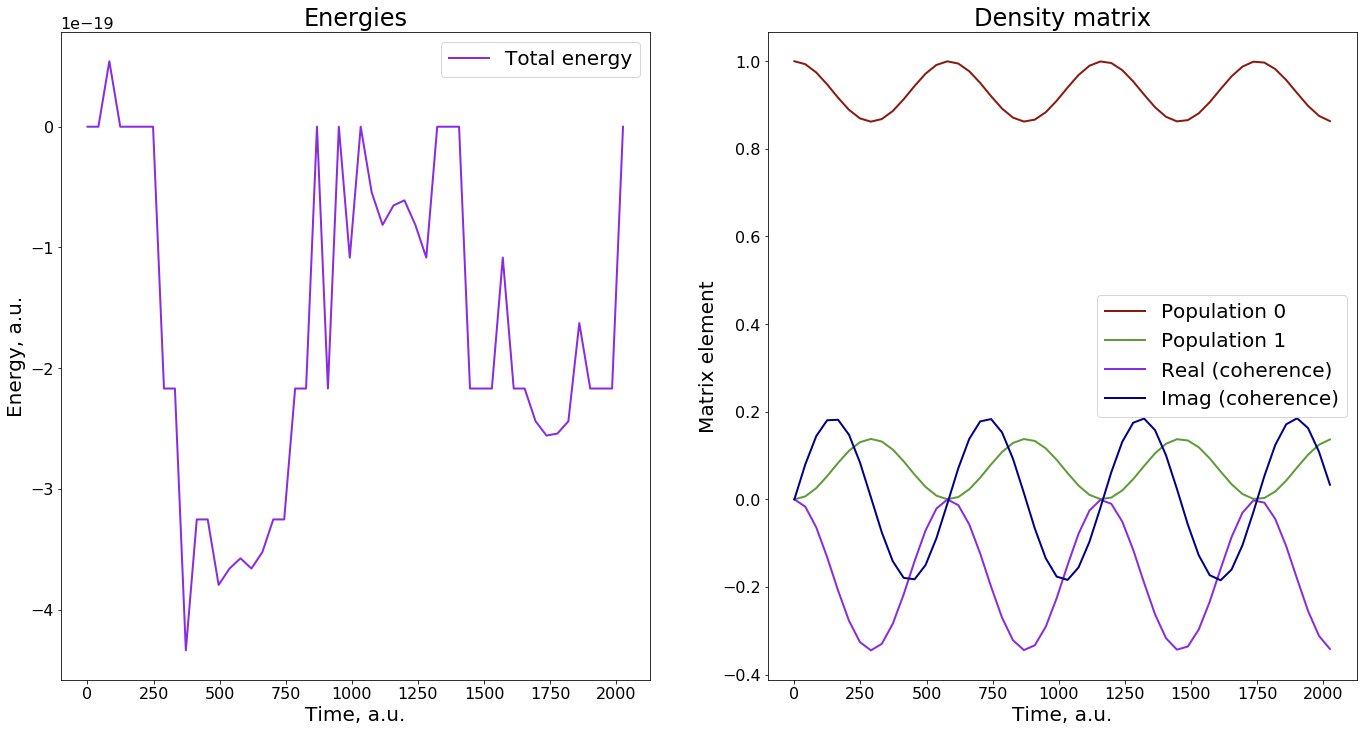

In [7]:
plot(T, Etot, p0, p1, p01_re, p01_im)

We observe that the total energy of the system is conserved, as expected.

The populations of the quantum states show persistent population transfer (Rabi oscillations). 

The coherence (real and imaginary components) does not decay and remains present in the system indefinitely. Thus, this is a fully coherent dynamics.

## 3. Dynamics of a dissipative (open) quantum system
<a name="open"></a> [Back to TOC](#TOC)

In this case, we add phenomenological "friction" terms to the QLE

\\[ \frac{\partial \hat \rho}{\partial t} = \frac{1}{i \hbar} [ \hat H, \hat \rho ]  - \gamma \tilde {\rho} \\]   (3a)

Here, $\tilde {\rho}$ is the density matrix $\rho$ with all the diagonal elements set to zero.

We need to adapt the function computing the derivative on the RHS accordingly

In [8]:
def derivatives2(rho, params):
    """
    rho - density matrix
    H - Hamiltonian computed using the input parameters
    
    -i * [H, rho] - gamma * rho = -i *( H * rho - rho * H) - gamma * rho
    
    """
    
    nstates = rho.num_of_rows    
    Ham = params["Ham"]    # CMATRIX 
    gamma = params["gamma"]    
                
    der = CMATRIX(nstates, nstates)
    
        
    fric = CMATRIX(rho)
    for i in range(nstates):
        fric.set(i,i, 0.0+0.0j)
        
    dE = ( Ham.get(1,1) - Ham.get(0,0) ).real
        
    
    der = (Ham * rho - rho * Ham) * (-1.0j) - gamma * fric
                    
    return der


In the simulation setup, we only add the "decoherence" parameter
<a name="qcl-2"></a><a name="RK4-2"></a>

In [9]:
def run_simulations2():
    
    # Initial conditions
    rho = CMATRIX(2, 2)
    rho.set(0,0, 1.0+0.0j);  rho.set(0,1, 0.0+0.0j);
    rho.set(1,0, 0.0+0.0j);  rho.set(1,1, 0.0+0.0j);
    
    # Potential
    Ham = CMATRIX(2,2)
    Ham.set(0,0, 0.0+0.0j);    Ham.set(0,1, 0.002+0.0j);
    Ham.set(1,0, 0.002+0.0j);  Ham.set(1,1, 0.01+0.0j);
    
    params = {"Ham":Ham, "gamma":0.001}

    # Simulation parameters
    dt = 1.0*units.fs2au
    nsteps = 500

    T, Etot, p0, p1, p01_re, p01_im = [], [], [], [], [], []
    for step in range(nsteps):    
        etot = energies(rho, params)
    
        T.append(step*dt)        
        Etot.append(etot)
        
        nrm = 1.0 #rho.tr().real
        p0.append(rho.get(0,0).real / nrm)
        p1.append(rho.get(1,1).real / nrm)
        p01_re.append(rho.get(0,1).real / nrm)
        p01_im.append(rho.get(0,1).imag / nrm)
                    
        rho = RK4(rho, dt, derivatives2, params)
    
    return T, Etot, p0, p1, p01_re, p01_im

In [10]:
T, Etot, p0, p1, p01_re, p01_im = run_simulations2()

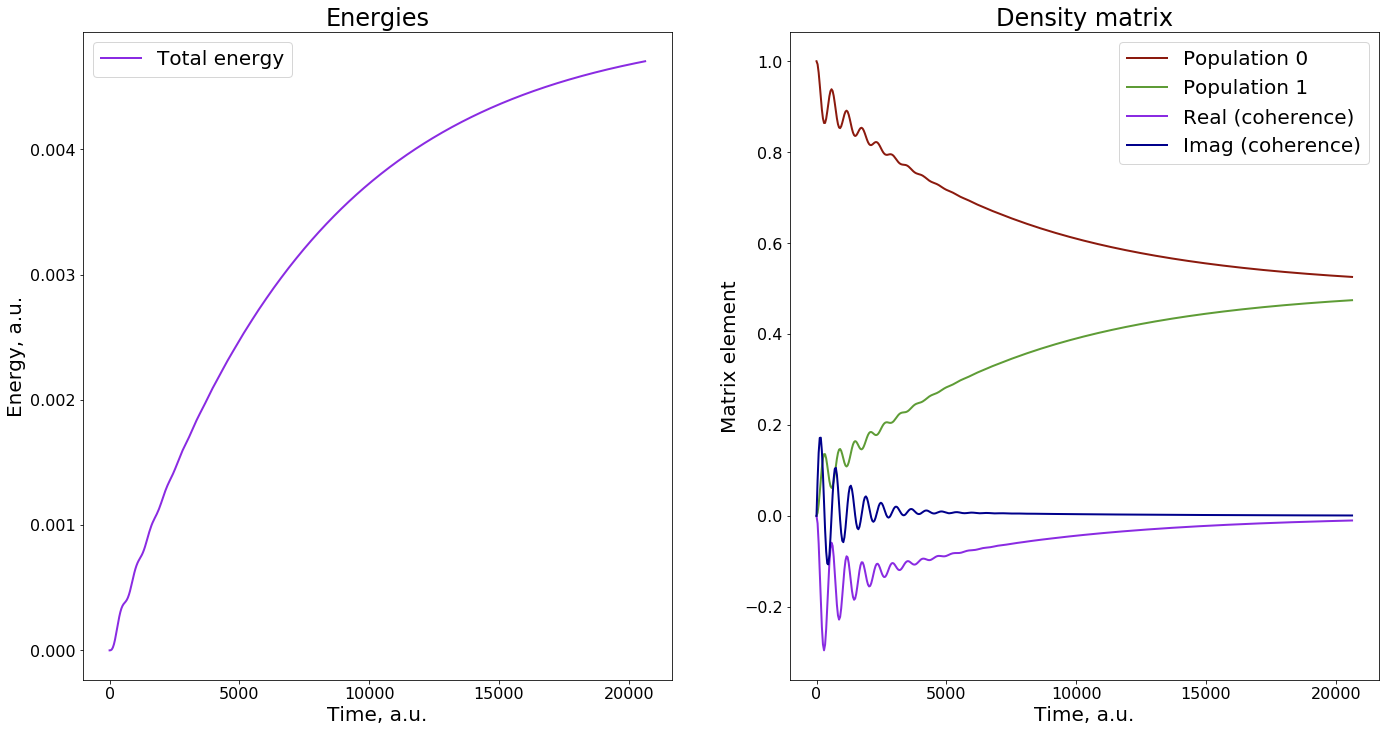

In [11]:
plot(T, Etot, p0, p1, p01_re, p01_im)

We can now observe that the total energy of such system is not conerved,coherences decay, and the populations converge to equal populations on each state. The latter behaviour means we don't capture thermal equilibration correctly, which is expected from the fact that the current approach is not too different from Ehrenfest dynamics and that the nuclei still stay frozen and are decoupled from the electronic degrees of fredom.